# TPGMM Example — JAX Backend

This notebook demonstrates the Task Parameterized Gaussian Mixture Model and
Gaussian Mixture Regression using the **JAX** backend.

Install dependencies with:
```bash
pip install tpgmm[jax,examples]
# or with uv:
uv sync --extra jax --extra examples
```

## 1. Imports

In [1]:
import sys
sys.path.append('..')

In [ ]:
import numpy as np
import jax.numpy as jnp

from tpgmm.jax import TPGMM, GaussianMixtureRegression
from tpgmm.utils.plot.plot import plot_trajectories, plot_ellipsoids, scatter

## 2. Generate synthetic trajectory data

We create a synthetic 3D trajectory and generate noisy variations of it.

In [3]:
np.random.seed(42)

# Base trajectory: a smooth curve in 3D
t = np.linspace(0, 2 * np.pi, 50)
base_trajectory = np.column_stack([np.cos(t), np.sin(t), t / (2 * np.pi)])

# Generate noisy demo trajectories
num_demos = 30
trajectories = []
for _ in range(num_demos):
    noise = np.random.normal(0, 0.02, size=base_trajectory.shape)
    trajectories.append(base_trajectory + noise)

trajectories = np.array(trajectories)
print(f"Generated {num_demos} demo trajectories with shape: {trajectories.shape}")

Generated 30 demo trajectories with shape: (30, 50, 3)


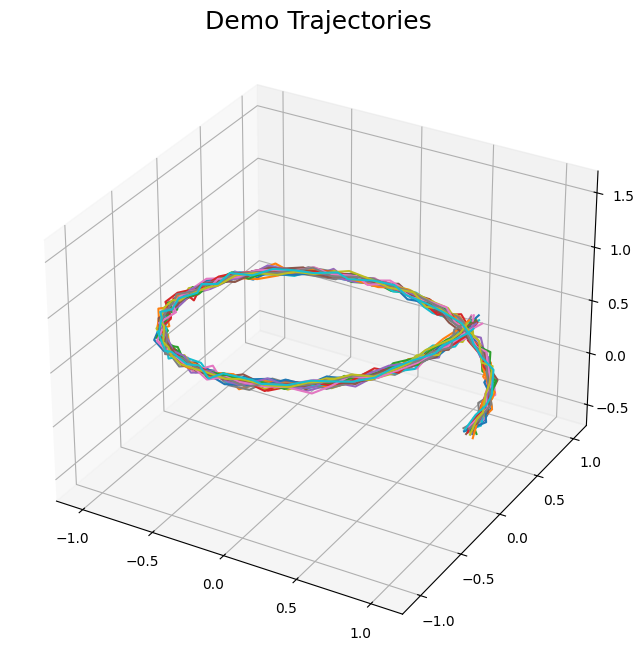

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'Demo Trajectories'}>)

In [4]:
plot_trajectories(title="Demo Trajectories", trajectories=trajectories, show=True)

## 3. Transform into local reference frames

Transform trajectories into start and end reference frames.

In [5]:
from tpgmm.utils.geometry import transform_into_frames

translations = np.stack([
    np.stack([-traj[0], -traj[-1]]) for traj in trajectories
])
rotations = np.tile(np.eye(3), (num_demos, 2, 1, 1))

local_trajectories = transform_into_frames(trajectories, translations, rotations)
print(f"Local trajectories shape: {local_trajectories.shape}")

Local trajectories shape: (30, 2, 50, 3)


## 4. Add time dimension and prepare data

In [6]:
num_points = local_trajectories.shape[2]
time_vec = np.linspace(0, 1, num_points)[:, None]

local_with_time = []
for demo in local_trajectories:
    frames_with_time = []
    for frame in demo:
        frames_with_time.append(np.concatenate([frame, time_vec], axis=-1))
    local_with_time.append(np.array(frames_with_time))

local_with_time = np.array(local_with_time)

# Concatenate all demos
concat_data = jnp.array(np.concatenate(local_with_time, axis=1))
print(f"Concatenated data shape: {concat_data.shape}")

Concatenated data shape: (2, 1500, 4)


## 5. Fit TPGMM (JAX backend)

Train the task-parameterized Gaussian mixture model using EM.

In [7]:
n_components = 8
tpgmm = TPGMM(n_components=n_components, verbose=True)
tpgmm.fit(concat_data)

print(f"\nWeights: {tpgmm.weights_}")
print(f"Means shape: {tpgmm.means_.shape}")
print(f"Covariances shape: {tpgmm.covariances_.shape}")

Started KMeans clustering
finished KMeans clustering
Start expectation maximization
Log likelihood: 3912.578125 improvement 20482.4609375
Log likelihood: 10075.171875 improvement 6162.59375
Log likelihood: 14296.740234375 improvement 4221.568359375
Log likelihood: 14675.724609375 improvement 378.984375
Log likelihood: 14882.4208984375 improvement 206.6962890625
Log likelihood: 15052.0625 improvement 169.6416015625
Log likelihood: 15099.271484375 improvement 47.208984375
Log likelihood: 15209.58984375 improvement 110.318359375
Log likelihood: 15284.23046875 improvement 74.640625
Log likelihood: 15327.64453125 improvement 43.4140625
Log likelihood: 15460.537109375 improvement 132.892578125
Log likelihood: 15573.42578125 improvement 112.888671875
Log likelihood: 15598.5546875 improvement 25.12890625
Log likelihood: 15618.12109375 improvement 19.56640625
Log likelihood: 15703.40234375 improvement 85.28125
Log likelihood: 15829.306640625 improvement 125.904296875
Log likelihood: 15864.13671

## 6. Visualize fitted GMM components

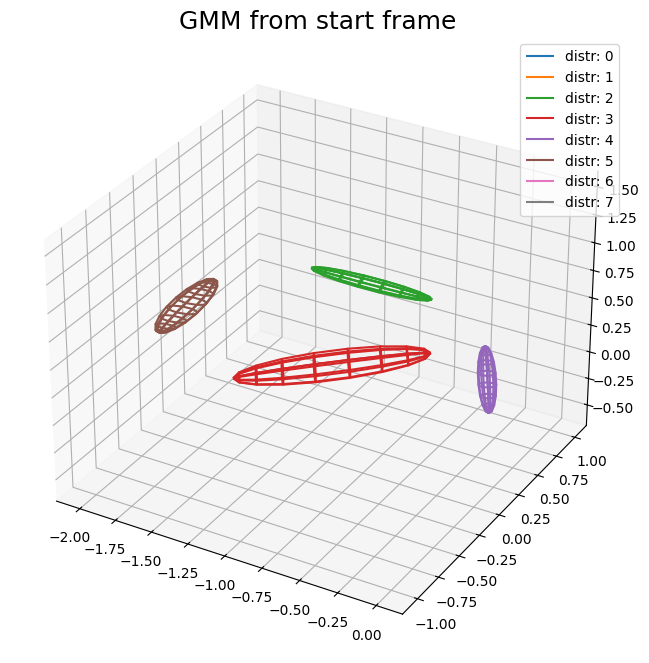

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'GMM from start frame'}>)

In [8]:
frame_idx = 0
plot_ellipsoids(
    title="GMM from start frame",
    means=np.asarray(tpgmm.means_[frame_idx, :, :3]),
    covs=np.asarray(tpgmm.covariances_[frame_idx, :, :3, :3]),
    legend=True,
    show=True,
)

## 7. Model selection via BIC

100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


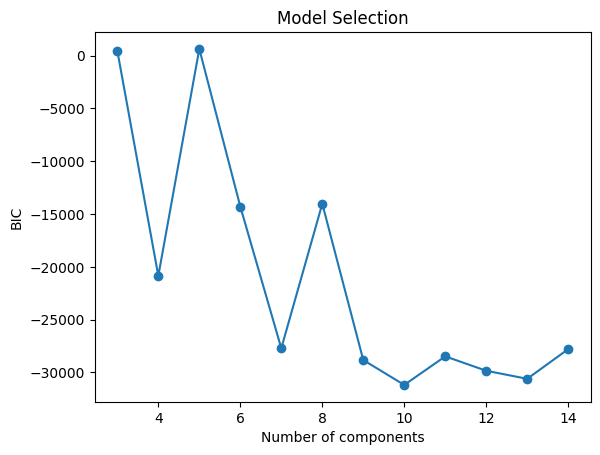

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt

K = np.arange(3, 15)
bic_scores = []
for k in tqdm(K):
    model = TPGMM(n_components=k, reg_factor=1e-3)
    model.fit(concat_data)
    bic_scores.append(float(model.bic(concat_data)))

fig, ax = plt.subplots()
ax.plot(K, bic_scores, marker="o")
ax.set_xlabel("Number of components")
ax.set_ylabel("BIC")
ax.set_title("Model Selection")
plt.show()

## 8. Gaussian Mixture Regression

Use the JAX GMR to reconstruct a trajectory for new start/end positions.

In [10]:
gmr = GaussianMixtureRegression.from_tpgmm(tpgmm, input_idx=[3])

translation = jnp.array([trajectories[0][0], trajectories[0][-1]])
rotation_matrix = jnp.tile(jnp.eye(3), (2, 1, 1))
gmr.fit(translation=translation, rotation_matrix=rotation_matrix)

input_data = jnp.linspace(0, 1, 100).reshape(-1, 1)
mu, cov = gmr.predict(input_data)
print(f"Predicted mean shape: {mu.shape}, covariance shape: {cov.shape}")

Predicted mean shape: (100, 3), covariance shape: (100, 3, 3)


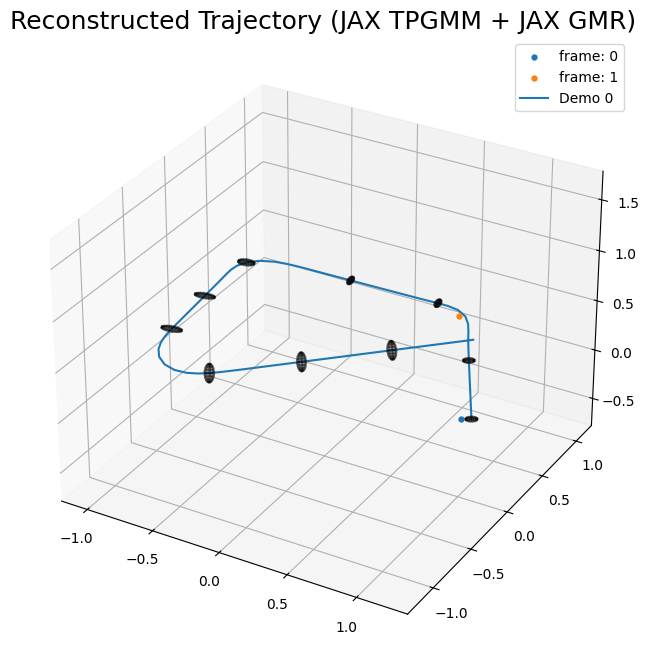

Distance to start: 0.0700
Distance to end: 0.3157


In [11]:
mu_np = np.asarray(mu)
cov_np = np.asarray(cov)
translation_np = np.asarray(translation)

fig, ax = scatter(title="Reconstructed Trajectory (JAX TPGMM + JAX GMR)", data=translation_np[:, None])
fig, ax = plot_trajectories(trajectories=mu_np[None], fig=fig, ax=ax, legend=True)
plot_ellipsoids(means=mu_np[::10], covs=cov_np[::10], fig=fig, ax=ax, color="k", alpha=0.3, show=True)

print(f"Distance to start: {np.linalg.norm(translation_np[0] - mu_np[0]):.4f}")
print(f"Distance to end: {np.linalg.norm(translation_np[1] - mu_np[-1]):.4f}")